**Chat processing library**

This notebook contains all the code necessary for:
  - segmentation of lemmatized chat + command files
  - segment analysis over these
  - matching chat messages to commands assigned to the segment
  - online processing for these, i.e. "live" results returned based on chat results only.
  
What it does not contain is the code to tokenize and lemmatize the inputs. Those will only make sense to include once the SQL server is ready. However, that code will also be there in the repo, simply as files.

All data used by the code - including lemmatized chat and command data for Neuro and Winter - are also included in the repo.

**Overview**

The purpose of the project was to understand the relationship between chat messages issued by players participating in the experiment and the commands performed by the actor, and, if applicable, build a program to infer commands from chat messages automatically. 

During the experiment, the inference bit was done by a live operator, who kept monitoring a chat channel, and then - supposedly - relayed the command that was the most popular on the channel. Or, rather, this is how it would have been in an ideal world.

In practice, there were technical problems that often prevented users from entering commands, operators apparently took autonomous decisions etc. We investigate this in detail in the paper draft I submitted, so I'll skip this here, and focus on implementation.

At a very high level, the matching algorithm is as follows:
1. Inputs are tokenized, word tokens lemmatized (=stemmed). Only verbs, nouns, and some special terms (e.g. "left") are kept.
2. The chat commands and the action commands are combed together, to form a single timeline of events. This is then "segmented", i.e. broken into segments that cover the multitude of chat messages issued between two consecutive action commands, as well as the command at the end of the segment. The segment is the unit for all offline calculations, charting etc.
3. Segment analysis is performed using multiple tests. The purpose of these tests is to match the chat commands over a segment to the command that is associated with the segment, and find matching algorithms that do the job well. Note: as operators often took autonomous decisions, the data was filtered manually for "good" segments, where this approach would presumably work. 

Additionally, charts are created. This was done in part to support the publication.
4. Charting.

Finally, if segment analysis yields good results, then we may confidently try inferring the action command automatically from the chat.
5. Online processing.

The code below will have all of this, although not necessarily in the same order. Also, there are some lower-level functions used across the board, so the structuring of the code will not follow the above breakdown to the letter.

**Tokenization / lemmatization**. Missing step for now FIXME.

The code snippet below is taken from the file base.py. It contains mostly class definitions and lower-level functions required for offline and online processing. Let us investigate them.

**Class definitions.**
This is just the Event and Segment classes, both are very simple, used mainly for data abstraction. 

An "event" describes an event, which is either a chat command or an actor command. The most important features of it are
 - a timestamp,
 - an actor (either a user id or the string '_ACTOR_'),
 - a type distintion between chat and action command events (equivalent to actor=='_ACTOR_'),
 - the command itself.
 
 A "segment" is a time-sorted list of events. It has associated with it:
 - a start time and end time (start=time stamp of first chat message in the segment, end=time of closing command),
 - a list of chat messages in that time range (list of Event)
 - the closing command. For better representation, this is separated from the chat entries into its own (type Event).
 

**Utility functions.**
These are very simple and self-explanatory for the most part. All, but one of them are related to time -- converting tuple representations of time to integer and back, calculating differences etc.

The one exception is the function read_sources. This is the one that reads in the input CSV-s, both chat and command, and returns a time-sorted list of Event objects.

**Event-level functions.**
These are two very similar functions, one of them generates all bi-grams from a string, the other essentially adds a weight to the entries of the first's output. Currently these weights are constant, so the second function does not appear too useful.

**Segment-level functions.**
These functions operate on entire segments. build_segments builds segments (i.e. converts a timeline segment into a Segment object), "stat_segment" generates a tally of words / bi-grams for a segment, calc_scores runs plug-in match functions on a segment summary (as output by stat_segment).


That concludes our discussion of the code segment directly below.

In [2]:
import codecs
import csv
import sys

import matplotlib.pyplot as plt

#####################
# Class definitions #
#####################

"""
The Event class handles basic information related to 'events'. These evets are 
either a chat message or an action performed by the actor.
"""
class Event:
    eventctr = 0
    def __init__(self, time, typ, actor, command, literal_command):
        if type(time) == tuple:
            self.timestamp = time
        elif type(time) == str:
            self.timestamp = clock2tuple(time)
        else:
            assert(0)
        
        self.actor = actor
        self.type = typ.lower()
        self.ctr = Event.eventctr
        self.command = command
        self.original_command = literal_command
        Event.eventctr += +1

    def __str__(self):
        return "{0}: {1}, {2}, type {3}, '{4}'".format(self.ctr,
            self.actor, self.timestamp, self.type, self.command)

"""
The Segment class represents an 'action segment', i.e. a time interval that
culminates in the actor confirming a command. Thus, these segments contain
the following events:
    - an arbitrary number of chat message events
    - a single action command.
"""
class Segment:
    """
    Contructor
    """
    def __init__(self, start_time, end_time, command, entries):
        self.start_time = start_time
        self.end_time = end_time
        self.command = command
        self.entries = entries
        self.mlclass = 0

    """
    String representation of the object
    """
    def __str__(self):
        s =  ["SEGMENT {0}-{1}".format(self.start_time, self.end_time)]
        s.append("    Command: " + self.command.__str__())
        for e in self.entries:
            s.append("\t" + e.__str__())
        return '\n'.join(s)

    """
    The filter trims the segment by removing all chat messages outside the
    specified time interval. The segment's time coverage interval is trimmed
    along the way, so subsequent calls to this function with a filter value
    that is a proper subset of [0, 1] will keep cutting the segment.
    Therefore, in typical use this function should not be called more than
    once on a segment.
    """
    def filter(self, fracs = [0, 1]):
        if len(self.entries) < 3:
            return

        t1 = tuple2int(self.entries[0].timestamp)
        t2 = tuple2int(self.entries[-1].timestamp)
        diff = t2 - t1

        newvals = (int(fracs[0] * diff + t1), int(fracs[1] * diff + t1))

        newents = []
        for e in self.entries:
            t = tuple2int(e.timestamp)
            if t < newvals[0] or t > newvals[1]:
                continue
            newents.append(e)
        if len(newents) > 0:
            self.start_time = newents[0].timestamp
            self.end_time = newents[-1].timestamp
        else:
            self.start_time = -1
            self.end_time = -1
        self.entries = newents

#####################
# Utility functions #
#####################


"""
Convert time integer value to a tuple of (hour, minute, second, millisecond).
"""
def clock2tuple(stamp):
    xl = stamp.split(':')
    assert(len(xl) == 3)
    xl2 = xl[2].split(',')
    assert(len(xl2) == 2)

    return (int(xl[0]), int(xl[1]), int(xl2[0]), int(xl2[1]))

"""
Convert time tuple value (hour, minute, second, millisecond) to integer.
"""
def tuple2int(stamp):
    return 3600000 * stamp[0] + 60000 * stamp[1] + 1000 * stamp[2] + stamp[3]

def int2tuple(t):
    hour = t // 3600000
    carry = t % 3600000
    minute = carry // 60000
    carry = carry % 60000
    second = carry // 1000
    carry = carry % 1000

    return (hour, minute, second, carry)

"""
Read chat and action source files and return them as a time-sorted list of
events.
"""
def read_sources(srt, chat):
    res_unso = []
    with codecs.open(srt, 'rt') as srtf:
        srt_reader = csv.reader(srtf, delimiter = ',')
        for e in srt_reader:
            assert(len(e) == 4)
            if e[2] != '':
                ee = Event(e[1], 'r', '_ACTOR_', e[2].lower(), e[3])
                res_unso.append(ee)

    with codecs.open(chat, 'rt') as chf:
        ch_reader = csv.reader(chf, delimiter = ',')
        for e in ch_reader:
            assert(len(e) == 4)
            ee = Event(e[0], '_', e[1], e[2].lower(), e[3])
            res_unso.append(ee)
           

    #now sort
    sorter = [(x.timestamp, x) for x in res_unso]
    return [x[1] for x in sorted(sorter)]

"""
Compares two time tuples, returns -1 if the first one is smaller, +1 if the
second, and 0 if they are equal.
"""
def timerel(a, b):
    for i in range(4):
        if a[i] < b[i]:
            return -1
        if b[i] < a[i]:
            return 1
    return 0

"""
Return the difference between two time tuples in milliseconds.
"""
def difftm(tm, diffms, setto0=False):
    tval = 3600000 * tm[0] + 60000 * tm[1] + 1000 * tm[2] + tm[3]
    if setto0:
        if tval < diffms:
            return (0, 0, 0, 0)
    newt = tval - diffms
    return int2tuple(newt)


#########################
# Event-level functions #
#########################

"""
Creates all word pairs of a string of words retaining the order.
The inputs are expected to be pos-tagged, e.g. "do+v", so the words are actually the first len-2 characters of 
the string.
"""
def twocombos(l):
    if len(l) == 0:
        return []
    elif len(l) == 1:
        return [[l[0][:-2]]]

    result = []
    for i in range(len(l) - 1):
        for j in range(i + 1, len(l)):
            result.append([l[i][:-2], l[j][:-2]])
    return result

"""
Creates a weighted list of bi-grams. 
As weights associated with each bi-gram constant in the current implementation, the function doesn't seem to 
do much beyond repackaging the output of twocombos.
"""
def nvkeys(words):
    assert(len(words) > 0)

    initcands = twocombos(words)

    result = [(' '.join(x), 1.0) for x in initcands]

    if len(initcands[0]) == 1:
        key = initcands[0][0]
        return result

    return result



###########################
# Segment-level functions #
###########################

"""
Converts a time-sorted representation of the input events into segments.
"""
def build_segments(timeline, opdelay):
    result = []
    actl = [i for i in range(len(timeline)) if timeline[i].actor == '_ACTOR_']
    start = 0
    for e in actl:
        nt = difftm(timeline[e].timestamp, opdelay)
        start_time = nt
        end_time = nt
        entries = []
        for i in range(start, len(timeline)):
            if timeline[i].actor == '_ACTOR_':
                continue
            if timerel(timeline[i].timestamp, nt) == -1:
                entries.append(timeline[i])
                if i == start:
                    start_time = timeline[i].timestamp
                end_time = timeline[i].timestamp
            else:
                break
        start = i

        sg = Segment(start_time, end_time, timeline[e], entries)
        result.append(sg)

    return result



"""
Calculates match scores based on a variety of tests. Tests are specified in
the variable sctests.
"""
def calc_scores(command, sctests, statted, mem, orig_command):
    for e in sctests:
        if e[0] not in mem:
            mem[e[0]] = (0, 0)
        sc = e[1](command, statted, tuple2int(orig_command.timestamp))
        mem[e[0]] = (mem[e[0]][0] + sc, mem[e[0]][1] + 1)

"""
Collects statistics for a segment.
"""
def stat_segment(segment):
    mem = {'n': {}, 'v': {}, 't': {}}

    for e in segment.entries:
        assert(e.actor != '_ACTOR_')
        wlist = e.command.split(' ')
        tkeys = nvkeys(wlist)

        for e2 in tkeys:
            if e2[0] not in mem['t']:
                mem['t'][e2[0]] = []
            tt0 = e.timestamp
            tt = 3600000 * tt0[0] + 60000 * tt0[1] + 1000 * tt0[2] + tt0[3]
            mem['t'][e2[0]].append(tt)

        for e2 in wlist:
            xl = e2.split('+')
            key = xl[1]
            k2 = xl[0]
            if k2 not in mem[key]:
                mem[key][k2] = []
            tt0 = e.timestamp
            tt = 3600000 * tt0[0] + 60000 * tt0[1] + 1000 * tt0[2] + tt0[3]
            mem[key][k2].append(tt)



    for e2 in ['n', 'v', 't']:
        sorter = list(reversed(sorted([(len(v), k, v) for 
            k, v in mem[e2].items()])))
        mem[e2] = sorter
    return mem



The next code snippet is a Jupyter import of the file segstatter.py. This function collects various statistics about the input, primarily for the purpose of studying the data. These functions do not play a role in the inference process, they simply add to our investigation of chat messages. Therefore, we do not need to discuss them at length -- all necessary documentation is below, embedded in the code.

In [3]:
import numpy as np

"""
These functions compute segment statistics for various charting purposes.
"""

"""
This function computes summary segment statistics -- number of words, unique
    words, segment lengths, variances etc.
These statistics help us formulate a better idea of what user commands look
    like.
"""
def overall1(seg, result):
    result['nentries'] = len(seg.entries)
    result['nseconds'] = (tuple2int(seg.end_time) - 
        tuple2int(seg.start_time)) // 1000
    lens = []        
    for e in seg.entries:
        lens.append(len(e.command.split(' ')))
    if len(seg.entries) == 0:

        result['average_len'] = 0
        result['std_len'] = 0
        result['rel_std_len'] = 0
    else:
        result['average_len'] = int(100 * np.average(lens))
        result['std_len'] = int(100 * np.std(lens))
        result['rel_std_len'] = int(100 * result['std_len'] / result['average_len'])

"""
This function computes calculates user command word statistics, in particular,
    word lengths.
"""
def calclangstats(seg, collected, result):
    result['nuniquewords'] = len(collected['n']) + len(collected['v'])
    result['nwords'] = sum([len(x[2]) for x in collected['n']]) +\
        sum([len(x[2]) for x in collected['v']])

    for e in ['nuniquewords', 'nwords']:
        key = 'rel' + e
        if result['nentries'] > 0:
            result[key] = int(100 * result[e] / float(result['nentries']))
        else:
            result[key] = -1

"""
This function handles the entire stats generation process by calling
    subordinate computation functions.
"""
def calcsegstats(seg, collected):
    result = {}

    overall1(seg, result)
    calclangstats(seg, collected, result)

    return result


The next code section contains the match functions. The file is testcalcs.py. All functions in this file have the same parametrization and output - they are designed to be called from the function calc_scores above (or in base.py).

While there is rich documentation embedded in the code, the motivations and historical perspective should improve the reader's understanding of what is below, as they developed organically. Coincidentally, the order of functions in the file is actually chronological, so by going down the list of functions, we move from simple to complex.

All the functions have the same purpose: match an action command to the commands extracted from the text -- in these particular functions it will always be done on the bi-grams. With one exception, our functions will return a binary score, with value 1 if and only if the action command "matches" one of the "most relevant" bi-grams, where both the notion of relevance, the number of relevant bi-grams as well as the match algorithm itself varies among the functions below.

**1. full match**
The full match is a very naive, simple match: compares the most frequent bi-gram to the action command using an exact string match, and returns 1 if and only if there is a match.

Analysis: 
- very particular, "most frequent" is not a well-defined ordering (there are draws), 
- the most frequent bi-gram for the segment is not always the winner, 
- the function does not handle paraphrasing. 

Altogether, low precision.

**2. loose full match**
The loose full match test is a full match performed on the few most frequent bi-grams. It returns 1 if and only if there is a match.

Analysis: 
- has better results than the full match, but not impressive,
- bi-gram frequency is not well-defined, 
- the addition of the second and third most frequent bi-gram has large positive impact, which makes this an unattractive method: not too accurate overall, plus we would always estimate *a* popular command to be the winner, but we would actually not hit the right one too often,
- the function does not handle paraphrasing.

Still low precision.
It seems like a natural idea to build something more robust with respect to paraphrasing, and see what that does do the score.

**3. bag of words**
This function considers both the action command and the chat command to be an unordered "bag" of words. Rather than returning a binary value, this function returns some kind of a relevance score.
The function compares the most frequent bi-grams to the action command, and returns as the score the maximum number of matching words (from a bi-gram) divided by the number of words in the action command -- this would be 0 for a no-match and 1 for a full match.

Analysis:
- Average accuracy was surprisingly high (60-70%), higher than the relative discrete score of the loose full match.
- This suggests that the few most frequent bi-grams usually have at least one of the terms from the action command.

This seem a very successful improvement over the full matches, so it should be developed into a binary test.

**4. indicator test**
This is a binarized bag of words method: the most frequent bi-grams are compared to the action command, and the first that contains at least half of the words (verb, noun, special terms) of the action command wins as the candidate.

Analysis:
- This function yielded over 80% on the Winter set accuracy on the top 5 bi-grams. Considering the treacherous nature of the text and some imperfections in the markup, this is a very good result.
- Another great feature is that the bi-gram that actually produced the match was quite often the most popular one (about 60% of all hits came from the most frequen bi-gram), so this could even be used as a predictor.

Still, the notion of time is not represented here: all chat messages have an equal weight in this test, some notion of time should be introduced.

**5. Moment test**
This test is essentially an indicator test on a resorted bi-gram list.
This test was designed to have some representation of moment. The name is legacy now, because it's not really a moment calculation anymore.
This function reassigns bi-gram "popularities": to each bi-gram it assigns the the root mean square of its time stamps, and uses that to measure popularity, rather than simple counts. As the RMS favors larger numbers, this function tends to attribute higher weight to bi-grams that has observations close to the end of the segment.
A small technical difference to the indicator function: a chat command is considered to match the action command if either:
- >= 50% of the action command's words are present in the chat command, or
- >= 80% of the chat command's words are present in the action command.

As we are talking about "bi-grams", which will have length 2 (or 1, in case the total chat command is just one word), the latter condition essentially says that we should match a chat command if its entire contents are present in the action command, even if the 50% criterion doesn't hold because the action command is long. An example where this is relevant: chat command="tea", action command="make earl tea" (from "make earl grey tea").
Note: the 80% threshold might as well be 90% or 99%, no difference.

Analysis:
- results still improved over the indicator test, and the reordering seemed relevant. Accuracy close to 90% on the Winter set.
- it is unrealistic to expect improvements over this accuracy, because there is very little data, and data quality and erratic operator behavior makes the data unreliable.
- Oddly, the overall accuracy improved, but it was inferior to the indicator test when performed on the most popular bi-gram only.

The work is nearly finished, now need a function that is appropriate for online processing.

**6. Decay match**
This test has the same nature as the moment test: it resorts the segment's bi-grams and performs a modified indicator test on the top few candidates.
Here the sorting is done as follows:
- there is an input time stamp representing the current time, whether that's the actual current time as in online processing, or the segment's action command's time stamp
- chat messages beyond a certain time difference to this anchor time stamp are discarded,
- the remaining messages are weighted according to a square rooted harmonic function,
- candidates are sorted according to these weights.
The rest is exactly the same as in the moment test.

Analysis:
- overall accuracy was as good as for the moment test, but convergence was slightly slower, i.e. slightly underperformed compared to the moment and indicator tests when only examining the top 1 or 2 most popular bi-grams.

It is hard to tell the reason for this phenomenon, could quite possibly be erratic operator behavior. As discussed in the publication draft, users are happy as long as the action command is - loosely speaking - representative of the chat messages. However, since the decay test is designed for online processing, and is very comfy, it is the most appropriate of the above for online applications.

In [4]:
"""
The functions here compare an action command to the most popular chat commands
    by various comparison algorithms. 
They all have the same three arguments:
    - command: the action command, a string
    - incoming: the sorted tally of noun / verb / 2-combo popularities, derived
        from the chat messages.
    - time: the time stamp of the action command

"""

#*_maxindexs: max indices for the various tests below. See exact interpretation
#    under the test functions.
loose_full_match_maxindex = 3
bag_of_words_maxindex = 3
indicator_test_maxindex = 5
moment_test_maxindex = 5
decay_test_maxindex = 5
decay_cutoff_secs = 50
decay_dampener = 5 * 1000
"""
Full test: an exact string match between the action command and the most
    popular (=frequent) 2-combination. If the most popular hit is not unique,
    i.e. two or more 2-combinations have the same number of occurrences,
    result is undefined -- the basis of comparison is always the 2-combination
    that is the first on the popularity-sorted list.
The test returns 1 if and only if the test passes, 0 otherwise.
"""
def full_test(command, incoming, time):
    #nothing matches an empty list or an empty command
    if len(command) == 0 or (len(incoming['t']) == 0):
        return 0

    #a full match is ok...
    if incoming['t'][0][1] == command:
        print "FULL MATCH", command, incoming['t'][0]
        return 1

    #...but nothing else is
    return 0

"""
Loose full test: very much akin to the full test, but here the basis of 
    comparison is the first _n_ 2-combos, rather than the first only.
    Result may be undefined in case the popularity counts are not unique.
The test returns 1 if and only if the test passes, 0 otherwise.
"""
def loose_full_test(command, incoming, time):    
    #nothing matches an empty list or an empty command
    if len(command) == 0 or (len(incoming['t']) == 0):
        return 0

    #a full match on any of the most popular items is ok...
    for e in incoming['t'][:loose_full_match_maxindex]:
        if e[1] == command:
            return 1
    #...but nothing else is
    return 0

"""
Bag of words test: in contrast to the tests above, this test considers both
    chat 2-combos and action commands to be unsorted sets of words, rather than
    sorted strings. The test generates the word set for the action command,
    as well as the most popular 2-combos from chat commands, and for each 
    2-combination, it computes the fraction of words of the action command 
    that are in it.
    The return value is the maximum over all chat 2-combination considered.
This function returns a fractional value on [0,1], signifying match strength.
"""
def bagofwords1(command, incoming, time):    
    combow = set(command.split())
    #nothing matches an empty list or an empty command
    if len(incoming['t']) == 0 or len(combow) == 0:
        return 0

    reslst = []
    #for each chat command, calculate the set and measure it against the
    #action command set.
    for e in incoming['t'][:bag_of_words_maxindex]:
        bow2 = set(e[1].split())
        cnt = 0
        for e2 in bow2:
            if e2 in combow:
                cnt += 1
        reslst.append(cnt)                

    #return the max        
    return max(reslst) / float(len(combow))

"""
Indicator test: a discretized version of the bag of words test. Both the
    action command and the chat 2-combo is converted into a bag of words,
    but rather than returning the highest fractional match, this function
    returns 1 if and only if one of the 2-combinations contain at least
    half of the action command's words, and 0 otherwise.
"""
def indicator_test(command, incoming, time):    
    combow = set(command.split())
    #nothing matches an empty list or an empty command
    if len(incoming['t']) == 0 or len(combow) == 0:
        return 0

    reslst = []
    for e in incoming['t'][:indicator_test_maxindex]:
        bow2 = set(e[1].split())
        if len(combow.intersection(bow2)) >= 0.5 * len(combow):
            print "INDI MATCH!: {0}".format(e)
            return 1

    return 0

"""
Moment test: the moment test is very similar to the indicator test in terms
    of the matching, but it resorts the 2-combo candidate list based on
        weight and "moment".
    Each 2-combination is assigned the root mean square value of the time stamps
        it appeared at. This will produce a bias towards end of the segment.
    Matching is similar to the indicator, in that it will produce a match on
        a candidate if the candidate contains at least half of the words from
        the action command. Unlike the indicator, this function will also
        produce a match if the action command contains at least 80% of the
        candidate's terms. This is a simple heuristic addition, meant to
        deal with long action commands and short 2-combos (e.g. action=
        "make earl tea", chat="tea"). Note that the "2-combo" here is a 
        single word, as the input was a single word..
Returns 1 if and only if there was a match, 0 otherwise.
"""
def moment_test(command, incoming, time):
    combow = set(command.split())
    #nothing matches an empty list or an empty command
    if len(incoming['t']) == 0 or len(combow) == 0:
        return 0
    moments = []
    #produce the root mean square value for each 2-combo on the entire 
    #2-combo set.
    for e in incoming['t']:
        assert(e[0] > 0)
        m1 = 0
        wt = 0
        for i2 in range(e[0]):
            m1 += (1*i2+1)*e[2][i2]**2
            wt += 1.0
        m1 = (m1/wt)**0.5

        moments.append((m1, e[1]))

    #inverse sort by RMS value        
    std = list(reversed(sorted(moments)))
#    print "MOMENT:::", std[:5]

    combow = set(command.split())

    reslst = []
    #now, essentially an indicator test, with the difference outlined above
    for e in std[:moment_test_maxindex]:
        bow2 = set(e[1].split())
        li = len(combow.intersection(bow2))
        if li >= 0.5 * len(combow) or li >= 0.8 * len(bow2):
            print "MOMENT MATCH!: {0}".format(e)
            return 1


    return 0


"""
The decay test is a more sophisticated form of the moment test that goes 
    beyond the segmentation mentality, and support online computation mode.
    Sorting here (given an action command time stamp) is done as follows:
        1. all 2-combos whose time is beyond a certain distance from the
            action time stamp are ignored.
        2. For all remaining time stamps, the weight associated with that
            time stamp is proportional to 1/sqrt(d+x), where x is the
            time difference from the action time, and d is a dampening 
            constant, to avoid a bias towards instances very close to the
            action time stamp.
    Once sorted as above, matching is identical to the way seen in the moment
        test.
"""
def decay_test(command, incoming, time):
    cutoff = decay_cutoff_secs * 1000

    combow = set(command.split())
    #nothing matches an empty list or an empty command
    if len(incoming['t']) == 0 or len(combow) == 0:
        return 0

    bydecay = []
    #calculate weights by decay
    for e0 in incoming['t']:
        assert(e0[0] > 0)
        e = (e0[0], e0[1], 
            [x for x in e0[2] if x <= time and time - x < cutoff])

        m1 = 0
        wt = 0
        for xx in e[2]:
            wt += 1000.0 / ((time + decay_dampener - xx) ** 0.5)

        bydecay.append((wt, e[1]))
    std = list(reversed(sorted(bydecay)))
    print "DECAY:::", std[:1]

    combow = set(command.split())

    reslst = []
    for e in std[:decay_test_maxindex]:
        bow2 = set(e[1].split())
        li = len(combow.intersection(bow2))
        if li >= 0.5 * len(combow) or li >= 0.8 * len(bow2):
            print "DECAY MATCH!: {0}".format(e)
            return 1


    return 0






In [5]:
import codecs
import csv
import sys

import matplotlib.pyplot as plt

"""
Some settings: test to perform on segments, operator delay.
"""
sctests = [('full', full_test), ('loose_full', loose_full_test),
    ('b_o_w', bagofwords1), ('indicator', indicator_test),
    ('moment', moment_test), ('decay', decay_test)]

operator_delay = 1000

"""
The chat evals contain a classification related to the Winter and Neuro inputs.
The classification aims to determine, which segments are usable.
"""
chatevals = {
    'winter': {
        'good': set([0, 1, 3, 5, 6, 8, 10, 12, 13, 14, 18, 19, 32, 34, 42, 43,
    45, 47, 48, 49, 50, 52, 54, 64, 66, 67, 72, 74, 75, 76, 83, 84, 85]),

        'notsure': set([2, 7, 9, 11, 17, 21, 26,38, 51, 53, 78, 79, 90]),

        'bad': set([4, 15, 16, 22, 23, 25, 27, 28, 29, 30, 31, 33, 35, 36, 37, 39,
            40, 44, 46, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 68, 69, 70, 71, 73,
            77, 80, 81, 82, 86, 87, 88, 89, 91])
    },
    'neuro': {
        'good': set([13,14,19,22,36,38,39,42,47,58,66,67,71,72,73,74,75,81,84]),
        'notsure': set([4,23,57,76]),
        'bad': set([0,1,2,3,5,6,7,8,9,10,11,12,15,16,17,18,20,21,24,25,26,27,
            28,29,30,31,32,33,34,35,37,40,41,43,44,45,46,48,49,50,51,52,53,54,
            55,56,59,60,61,62,63,64,65,68,69,70,77,78,79,80,82,83]),
        }
}

filter_out = ['bad', 'notsure']

"""
Determine is the segment is to be considered for processing. This is based
on the manual evaluation contained in chatevals.
"""
def segment_ok(seg, fltr, scenario):
    for e in fltr:
        if seg.command.ctr in chatevals[scenario][e]:
            return False
    return True

"""
This function extracts all relevant statistics from a segment.
memvec is designed to be used for matching, statvec for analysis / charting.
"""
def summarize_segments(segments):
    #initialize the result variables
    memvec = []
    statvec = []

    for i1, e in enumerate(segments):
        #filter out initial part of the segment
        e.filter((0.4, 1))

        #prepare and store segment stats for analysis / plotting
        mem = stat_segment(e)
        rr = calcsegstats(e, mem)

        memvec.append(mem)
        statvec.append(rr)

    return memvec, statvec

"""
Segments' chat summary information (memvec) matched against their
action commands using various tests.
"""
def match_segments(segments, memvec, tests, scenario_name):
    scores = {}
    #now 
    for i1, e in enumerate(segments):
        if len(e.entries) == 0:
            continue

        if not segment_ok(e, filter_out, scenario_name):
            continue

        #the following line is useful for studying the problem, but should
        #be commented out when doing online processing.

#        e.filter((0.4, 1))
        tkl0 = e.command.command.lower().split(' ')
        tkl = []
        oktoks = []
        for e2 in tkl0:
            print e2, tkl0
            if e2.find('+') == -1: #indicates a lemmatization error
                print "AAA", e2, tkl0
                quit()
            ll = e2.split('+')
            if ll[0] != '' and ll[1] in ['n', 'v']:
                tkl.append(e2)
                oktoks.append(ll[0])
        proc_cmd = ' '.join(oktoks)

        #print what needs printing
        print "\n=================\nSEGMENT", e.command, '|', \
            proc_cmd
        print "\t", memvec[i1]['n'][:5] 
        print "\t", memvec[i1]['v'][:5] 
        print "\t", memvec[i1]['t'][:5] 
        calc_scores(proc_cmd, tests, memvec[i1], scores, e.command)
        if moment_test(proc_cmd, memvec[i1], tuple2int(e.command.timestamp)):
            e.mlclass = 1
        for i2, e2 in enumerate(memvec[i1]['t'][:5]):
            print "\t", e2
#            plt.plot(e2[2], range(len(e2[2])), label='kax{0}'.format(i2))

    print scores

"""
Plotting. To be refined.
"""
def plot_results(segments, statvec):
    reskeys = statvec[0].keys()
    for e in reskeys:
        print "PLOT FOR KEY {0}".format(e)
        good = [x[e] for i, x in enumerate(statvec) if segments[i].mlclass==1]
        bad = [x[e] for i, x in enumerate(statvec) if segments[i].mlclass==0] #use for unfiltered
        ax1=plt.subplot(2,1,1)
        plt.xlabel('xx')
#        plt.xticks([rangie(10)]), plt.yticks([])
        plt.grid=True
        plt.title('good for {0}'.format(e))
        plt.hist(good, bins=30)

        ax2=plt.subplot(2,1,2, sharex=ax1)
#        plt.xticks([]), plt.yticks([])
        plt.title('bad for {0}'.format(e))
        plt.grid=True
        plt.hist(bad, bins=30)
        plt.show()
        
"""
This function provides a one-stop shopping option for all required 
functionality.
"""
def doall(srtf, chatf, scenario, doplot):

    timeline = read_sources(srtf, chatf)
    segments = build_segments(timeline, operator_delay)

    memvec, statvec = summarize_segments(segments)

    match_segments(segments, memvec, sctests, scenario)
   
    if doplot:
        plot_results(segments, statvec)



make+v ['make+v', 'coffee+n']
coffee+n ['make+v', 'coffee+n']

SEGMENT 0: _ACTOR_, (0, 3, 31, 882), type r, 'make+v coffee+n' | make coffee
	[(16, 'command', [85000, 102000, 109000, 114000, 137001, 139000, 157003, 164000, 170000, 178001, 187003, 188000, 189000, 197000, 209000, 210000]), (9, 'it', [87001, 89000, 98000, 113000, 117002, 147001, 152000, 157000, 196000]), (7, 'coffee', [156000, 157004, 160000, 166000, 178000, 188000, 201001]), (5, 'website', [104000, 111000, 132000, 157001, 163000]), (5, 'site', [123001, 158000, 185000, 185001, 187004])]
	[(8, 'work', [117002, 118000, 147001, 163000, 164000, 172000, 184000, 209000]), (8, 'make', [156000, 157004, 166000, 176000, 178000, 183000, 201001, 204000]), (7, 'can', [109000, 137001, 157002, 184001, 187004, 188000, 201001]), (5, 'submit', [172000, 178001, 184000, 189000, 201002]), (4, 'do', [110000, 114000, 156000, 159000])]
	[(5, 'make coffee', [156000, 157004, 166000, 178000, 201001]), (4, 'website', [104000, 111000, 132000, 157001])

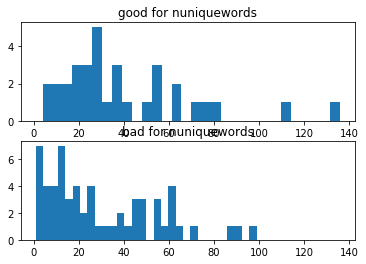

PLOT FOR KEY std_len


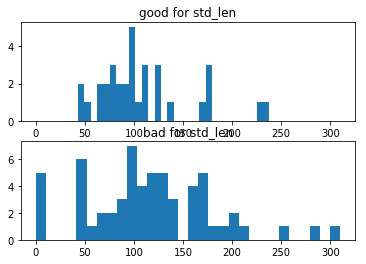

PLOT FOR KEY relnwords


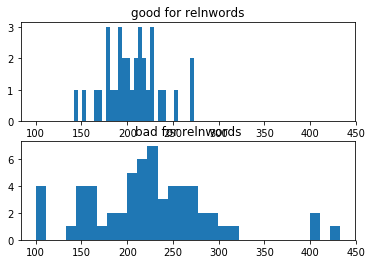

PLOT FOR KEY rel_std_len


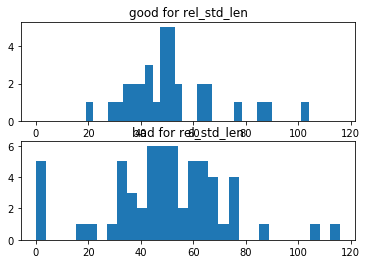

PLOT FOR KEY nwords


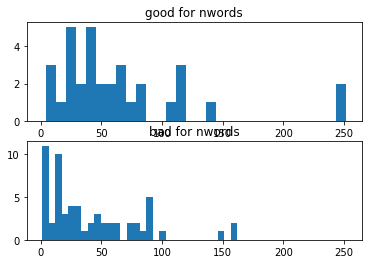

PLOT FOR KEY relnuniquewords


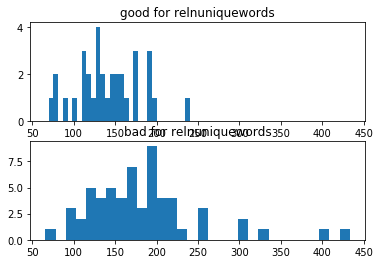

PLOT FOR KEY nseconds


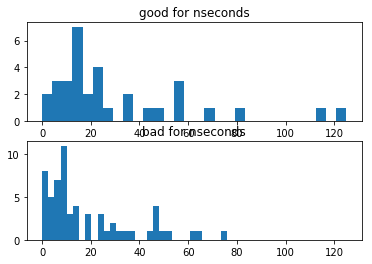

PLOT FOR KEY nentries


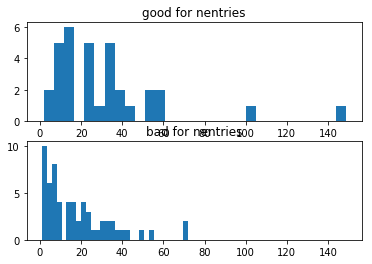

PLOT FOR KEY average_len


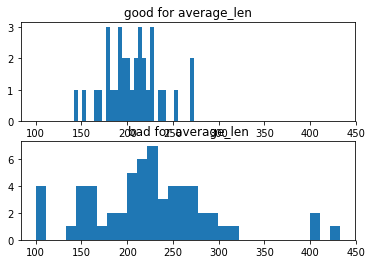

In [6]:
Segment.counter=0
Event.eventctr=0
doall('data/final/winter_lemmed_srt.csv', 'data/final/winter_lemmed_chat.csv', 'winter', 1)

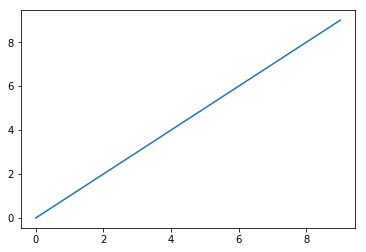

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(10), range(10))
plt.show()


In [32]:
def proc_online(srtf, chatf, scenario, doplot):

    timeline = read_sources(srtf, chatf)
    slidewindow = []
    maxdiffs = 50
    mdms = maxdiffs * 1000
    decay_dampener = 5 * 1000
    absthr = 30.0
    last_command = None
    result = []

    for e in timeline:
        #1 flush all old entries
        if e.actor == '_ACTOR_':
            continue

        slidewindow.append(e)
        mintime = difftm(slidewindow[-1].timestamp, mdms, setto0 = True)
        
        while True:
            if slidewindow[0].timestamp >= mintime:
                break
            x=slidewindow.pop(0)
            
        #2 tally all
        tm0 = tuple2int(slidewindow[-1].timestamp)
        tallier = {}

        for e2 in slidewindow:
            tm = tuple2int(e2.timestamp)
            kz = nvkeys(e2.command.split(' '))
            for e3 in kz:
                if e3 not in tallier:
                    tallier[e3] = {'score': 0, 'instances': []}
                tallier[e3]['score'] += 1000.0 / \
                    ((tm0 + decay_dampener - tm) ** 0.5)
                tallier[e3]['instances'].append(e2.original_command)

        srtr = list(reversed(sorted([(v['score'], k, v['instances'][-1]) 
            for k, v in tallier.items()])))

        if srtr[0][0] >= absthr:
            if srtr[0][1][0] != last_command:
                if (len(srtr) < 2) or (srtr[0][0] >= 2 * srtr[1][0]):
                    result.append((int2tuple(tm0), srtr[0][1][0], srtr[0][2]))
                    last_command = srtr[0][1][0]

    for e in result:
        print e



In [33]:
proc_online('data/final/winter_lemmed_srt.csv', 'data/final/winter_lemmed_chat.csv', 'winter', 0)

((0, 0, 51, 0), 'awaken', 'awaken')
((0, 2, 46, 0), 'make coffee', 'make coffee')
((0, 3, 30, 0), 'command work', "yeah, commands aren't working")
((0, 4, 34, 1), 'make coffee', 'got an ai to defeat? dont sweat it! make coffee!')
((0, 5, 32, 0), 'open fridge', 'open fridge')
((0, 5, 40, 0), 'make tea', 'make tea')
((0, 6, 24, 1), 'open fridge', 'open fridge')
((0, 7, 14, 0), 'walk', 'walk more')
((0, 7, 21, 0), 'do flip', 'do a flip')
((0, 7, 22, 1), 'walk', 'walk u dum dum')
((0, 7, 54, 1), 'tea', 'green tea')
((0, 8, 58, 1), 'sing', 'sing')
((0, 9, 0, 2), 'drink tea', 'drink tea')
((0, 9, 26, 2), 'sing', 'sing despacito 2')
((0, 10, 1, 2), 'cry', 'cry')
((0, 10, 23, 1), 'throw cup', 'throw the cup in the garbage')
((0, 11, 11, 4), 'water fountain', 'use water fountain')
((0, 11, 17, 0), 'open door', 'open door')
((0, 11, 22, 0), 'walk room', 'walk out of room')
((0, 11, 29, 0), 'cry', 'cry')
((0, 11, 43, 3), 'walk', 'walk down')
((0, 12, 6, 1), 'turn left', 'turn left')
((0, 12, 26, 

In [34]:
proc_online('data/final/neuro_lemmed_srt.csv', 'data/final/neuro_lemmed_chat.csv', 'neuro', 0)

((0, 0, 27, 0), 'rule rule', 'rule 1: there are no rules. rule 2: because rule 1 is a rule it will be ignored, there are rules.')
((0, 4, 50, 1), 'play', 'play foosball')
((0, 5, 14, 0), 'make coffee', 'make the coffee')
((0, 6, 9, 0), 'left right', 'obviously we need to use the cheat code, up up down down left right left right b a start')
((0, 6, 55, 1), 'page', 'page broken...')
((0, 7, 17, 1), 'pick nose', 'pick nose')
((0, 9, 28, 0), 'left right', 'up up down down left left right right b a start')
((0, 10, 43, 1), 'ask mug', 'ask for a mug')
((0, 10, 48, 0), 'make coffee', 'make coffee')
((0, 11, 8, 1), 'clean mug', 'clean mug first!!')
((0, 11, 15, 0), 'smash mug', 'smash mug')
((0, 12, 4, 0), 'look mirror', 'look in a mirror')
((0, 16, 59, 0), 'left right', 'have him do up up down down left right left right b a start')
((0, 17, 9, 0), 'find pc', 'find a pc')
((0, 17, 16, 0), 'left right', 'vote up up down down left right left right b a start')
((0, 17, 30, 1), 'stop jump', 'stop 